In [1]:
from astropy import units as u
from astropy import time
import astropy
import numpy as np

from poliastro import iod
from poliastro.bodies import Body,Mars, Earth, Venus, Jupiter, Saturn, Uranus, Neptune, Sun, Europa, Ganymede, Callisto, Io, Titan
from poliastro.ephem import Ephem
from poliastro.maneuver import Maneuver
from poliastro.twobody import Orbit
from poliastro.util import time_range
from poliastro.frames import Planes
from poliastro.frames.fixed import JupiterFixed
from poliastro.frames.equatorial import JupiterICRS
from astroquery.jplhorizons import Horizons
from copy import deepcopy

from scipy import ndimage
from scipy.spatial.transform import Rotation as scipyRot
from collections import defaultdict
from poliastro.plotting import OrbitPlotter3D, StaticOrbitPlotter
import math
import matplotlib.pyplot as plt
# More info: https://plotly.com/python/renderers/
import plotly.io as pio
from poliastro.util import norm, time_range
pio.renderers.default = "plotly_mimetype+notebook_connected"
import weakref
from astropy.coordinates import solar_system_ephemeris
from collections.abc import Mapping
from poliastro.extra_util import  match_astro_query_num, get_single_burn_elliptical_hohmann ,match_orbit_plane,  search_for_resonant_orbit,ecliptic_slingshot


solar_system_ephemeris.set("jpl")

<ScienceState solar_system_ephemeris: 'jpl'>

In [2]:
start_date= time.Time("2037-06-11 00:01", scale="utc").tdb
end_date= time.Time("2037-09-21 00:01", scale="utc").tdb
epochs=time_range(start=start_date,end=end_date,periods=50)

callisto_ephem = Ephem.from_horizons(504,epochs= epochs, attractor= Jupiter,plane=Planes.EARTH_ECLIPTIC)#Callisto is 504
callisto_orb= Orbit.from_ephem(attractor=Jupiter,ephem=callisto_ephem,epoch=start_date)

starship_orb=Orbit.from_classical(Jupiter, 1300000*u.km, 0.845*u.one, callisto_orb.inc, callisto_orb.raan, 0*u.deg, -10*u.deg,start_date,plane=Planes.EARTH_ECLIPTIC)
print(starship_orb.period.to(u.day))


/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "utctai" yielded 1 of "dubious year (Note 3)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"



9.575709772558454 d


In [3]:
def get_galilean_ephemerides(start_date, end_date, num_periods=50):
    """
    Generate ephemeris data for all Galilean moons.
    
    Parameters:
    -----------
    start_date : astropy.time.Time
        Start date for ephemeris
    end_date : astropy.time.Time
        End date for ephemeris
    num_periods : int
        Number of time steps for ephemeris
        
    Returns:
    --------
    dict : Dictionary mapping Body objects to their Ephem objects
    """
    epochs = time_range(start=start_date, end=end_date, periods=num_periods)
    
    # Dictionary mapping Body objects to their Horizons ID numbers
    galilean_ids = {
        Io: 501,
        Europa: 502,
        Ganymede: 503,
        Callisto: 504
    }
    
    # Generate ephemerides for each moon
    ephem_dict = {}
    for body, horizons_id in galilean_ids.items():
        ephem = Ephem.from_horizons(
            horizons_id,
            epochs=epochs,
            attractor=Jupiter,
            plane=Planes.EARTH_ECLIPTIC
        )
        ephem_dict[body] = ephem
    
    return ephem_dict

# Usage:
ephemerides = get_galilean_ephemerides(start_date, end_date)

# Access like this:
europa_ephem = ephemerides[Europa]
io_ephem = ephemerides[Io]
ganymede_ephem = ephemerides[Ganymede]
callisto_ephem = ephemerides[Callisto]

In [4]:
def get_galilean_orbs(start_date):
  
    #Generate orbit data for all Galilean moons.

    
    # Generate ephemerides for each moon
    orbit_dict = {}
    for body in [Io,Europa,Ganymede,Callisto]:
        orbit=Orbit.from_ephem(attractor=Jupiter,ephem=ephemerides[body],epoch=start_date)
        orbit_dict[body] = orbit
    
    return orbit_dict

# Usage:
galilean_orbs = get_galilean_orbs(start_date)

# Access like this:
europa_orb = galilean_orbs[Europa]
print(europa_orb)


665064 x 676992 km x 2.0 deg orbit around Jupiter (♃) at epoch 2037-06-11 00:02:09.185 (TDB)


In [5]:
europa_orb= Orbit.from_ephem(attractor=Jupiter,ephem=europa_ephem,epoch=start_date)
ganymede_orb= Orbit.from_ephem(attractor=Jupiter,ephem=ganymede_ephem,epoch=start_date)
io_orb= Orbit.from_ephem(attractor=Jupiter,ephem=io_ephem,epoch=start_date) 
callisto_orb= Orbit.from_ephem(attractor=Jupiter,ephem=callisto_ephem,epoch=start_date)

In [6]:
transfer=get_single_burn_elliptical_hohmann(
    callisto_orb,
    starship_orb,
    tof_step=0.01*u.day,
    max_tof=60*u.day,
    max_revs=3
)
print(transfer[0])

Getting ephems from 2037-06-11 00:19:26.489.
44.05783084640525 m / s


In [7]:
starship_flyby_orbit=transfer[1].propagate(transfer[2].epoch)
callisto_flyby_orbit=transfer[2]

In [8]:
ecliptic_slingshot(starship_flyby_orbit,callisto_flyby_orbit,Callisto,10*u.km,1)

(<Quantity [-7.04914889,  0.66865111, -0.05913129] km / s>,
 284789 x 2731306 km x 1.7 deg orbit around Jupiter (♃) at epoch 2037-06-23 03:41:03.489 (TDB))

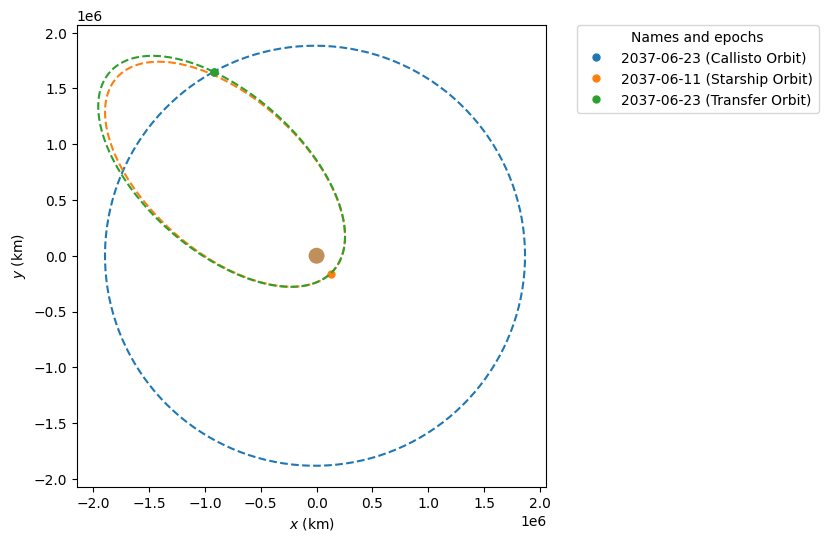

In [10]:
plotter=StaticOrbitPlotter(plane=Planes.EARTH_ECLIPTIC)
plotter.plot(callisto_flyby_orbit, label="Callisto Orbit")
plotter.plot(starship_orb, label="Starship Orbit")
plotter.plot(starship_flyby_orbit, label="Transfer Orbit")

In [11]:
#return 
def assist_possible_periods(spacecraft_orb, body_orb, body, r_p_min=10*u.km, r_p_max=5000*u.km, num_samples=500):#finds possible periods of orbit around attractor given flyby
    periods=np.zeros((num_samples,2))
    periaps=np.zeros((num_samples))
    attractor=spacecraft_orb.attractor
    flyby_dist=np.linalg.norm(spacecraft_orb.r-body_orb.r)
    if(flyby_dist)<2*body.R:
        rel_vel=spacecraft_orb.rv()[1]-body_orb.rv()[1]
        rel_speed=np.linalg.norm(rel_vel)
        r_ps = body.R + np.linspace(r_p_min.to(u.km).value, r_p_max.to(u.km).value, num=num_samples) * u.km
        rot_angs = 2 * np.arcsin(1 / ((r_ps * rel_speed**2 / body.k) + 1 * u.one))
        # Rotation axis in ecliptic plane
        axis = np.array([0, 0, 1.0])
        axis = axis / np.linalg.norm(axis)
        # Try both rotation directions (leading/trailing side flybys)
        for j,sign in enumerate([1,-1]):
            for i, rot_ang in enumerate(rot_angs):
                # Rotate the relative velocity
                rot = scipyRot.from_rotvec(sign * axis * rot_ang.value)
                rel_vel_out = rot.apply(rel_vel.value) * u.km / u.s
                
                # Calculate post-assist velocity in attractor frame
                post_assist_vel = rel_vel_out + body_orb.rv()[1]
                
                # Create orbit from post-assist state
                test_orb = Orbit.from_vectors(
                    attractor, 
                    body_orb.r, 
                    post_assist_vel, 
                    spacecraft_orb.epoch,
                    plane=Planes.EARTH_ECLIPTIC
                )
                periods[i][j]=test_orb.period.to(u.day).value
                periaps[i]=r_ps[i].to(u.km).value
        return (periods,periaps)
                
                
    else:
        print(f"Trajectory does not fly past {body} closely enough - misses by {flyby_dist.to(u.km):.1f}")
        return None

callisto_flyby_data=assist_possible_periods(starship_flyby_orbit,callisto_flyby_orbit,Callisto,r_p_max=10000*u.km)

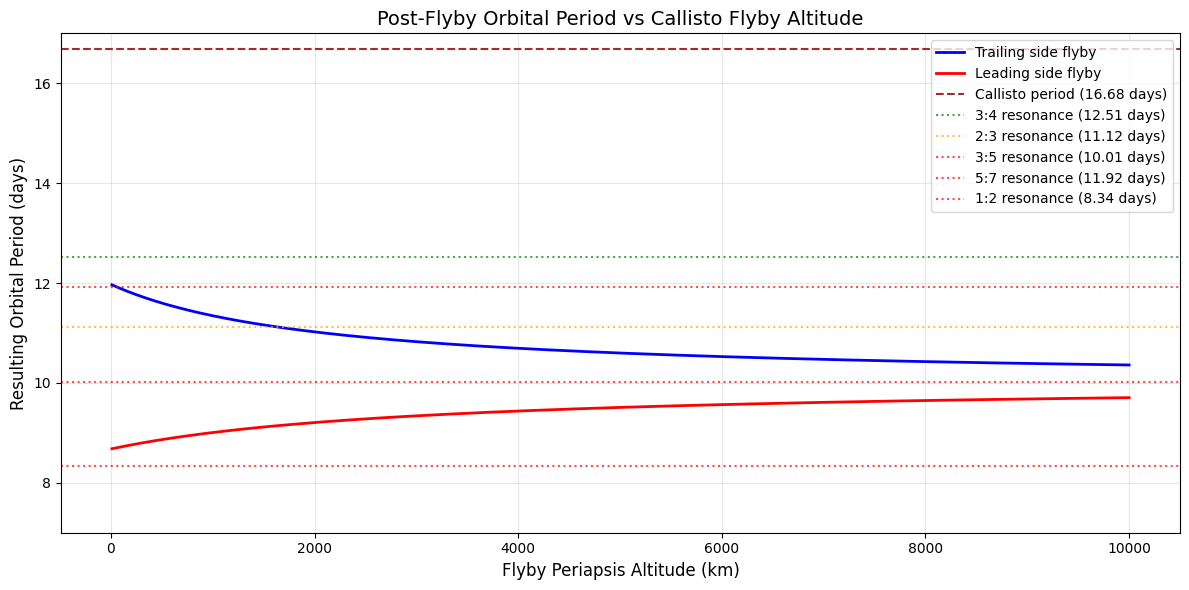

Callisto orbital period: 16.68 days

Trailing side flyby:
  Period range: 10.36 - 11.96 days

Leading side flyby:
  Period range: 8.68 - 9.70 days


In [12]:
# Plot period vs periapsis for both leading and trailing flybys
plt.figure(figsize=(12, 6))

periaps = callisto_flyby_data[1]-Callisto.R.to(u.km).value  # Periapsis altitudes
periods_trailing = callisto_flyby_data[0][:, 0]  # Trailing side (sign=1)
periods_leading = callisto_flyby_data[0][:, 1]  # Leading side (sign=-1)

plt.plot(periaps, periods_trailing, 'b-', label='Trailing side flyby', linewidth=2)
plt.plot(periaps, periods_leading, 'r-', label='Leading side flyby', linewidth=2)

# Add Callisto's orbital period as reference
callisto_period = callisto_orb.period.to(u.day).value
plt.axhline(y=callisto_period, color='brown', linestyle='--', 
            label=f'Callisto period ({callisto_period:.2f} days)', linewidth=1.5)

# Add resonance period references
plt.axhline(y=callisto_period * 3/4, color='green', linestyle=':', 
            label=f'3:4 resonance ({callisto_period * 3/4:.2f} days)', linewidth=1.5, alpha=0.7)
plt.axhline(y=callisto_period * 2/3, color='orange', linestyle=':', 
            label=f'2:3 resonance ({callisto_period * 2/3:.2f} days)', linewidth=1.5, alpha=0.7)
plt.axhline(y=callisto_period * 3/5, color='red', linestyle=':', 
            label=f'3:5 resonance ({callisto_period * 3/5:.2f} days)', linewidth=1.5, alpha=0.7)
plt.axhline(y=callisto_period * 5/7, color='red', linestyle=':', 
            label=f'5:7 resonance ({callisto_period * 5/7:.2f} days)', linewidth=1.5, alpha=0.7)
plt.axhline(y=callisto_period * 1/2, color='red', linestyle=':', 
            label=f'1:2 resonance ({callisto_period * 1/2:.2f} days)', linewidth=1.5, alpha=0.7)


plt.xlabel('Flyby Periapsis Altitude (km)', fontsize=12)
plt.ylabel('Resulting Orbital Period (days)', fontsize=12)
plt.title('Post-Flyby Orbital Period vs Callisto Flyby Altitude', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.ylim(bottom=7,top=17)

plt.show()

# Print some statistics
print(f"Callisto orbital period: {callisto_period:.2f} days")
print(f"\nTrailing side flyby:")
print(f"  Period range: {periods_trailing.min():.2f} - {periods_trailing.max():.2f} days")
print(f"\nLeading side flyby:")
print(f"  Period range: {periods_leading.min():.2f} - {periods_leading.max():.2f} days")

Leading side flybys give lower periods
0
1
Going for [2 3] resonance with periapsis at 1630.0650325162576 km
Time of flight is 33.4 d, which is 2 times the period of the moon.
Period of spacecraft orbit should be 11.1 d, actually is 11.1 d
Arrives with distance of 166.15 km


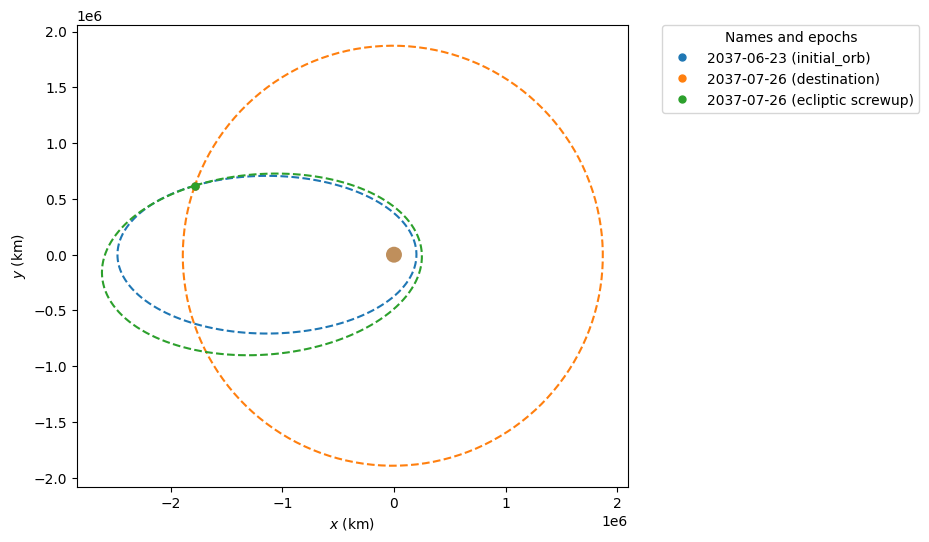

In [55]:
##from initial flyby, 

#Lower is if the resonance looks exclusively for lower period orbits, numerator_prioritize is if the resonance priortizes resonances
# with a lower number of spacecraft orbits (numerator is lower), max numerator is obvious (max number of spacecraft orbits before next encounter)
def resonance_search(spacecraft_orb,body,r_p_min=10*u.km, r_p_max=5000*u.km, lower=True, numerator_prioritize=True, max_numerator=9):
   
    prelim_body_orb= galilean_orbs[body].propagate(spacecraft_orb.epoch)
    postflyby_data=assist_possible_periods(spacecraft_orb, prelim_body_orb, body,r_p_min=r_p_min, r_p_max=r_p_max,num_samples=2000)
    possible_resonances=[]
    if postflyby_data is not None:
        ##Check which side gives lower periods
        trailing_mean_period = np.mean(postflyby_data[:][0])
        leading_mean_period = np.mean(postflyby_data[0][:, 1])
        if trailing_mean_period < leading_mean_period:
            lower_side = 0  # Trailing side (sign=1)
            print("Trailing side flybys give lower periods")
        else:
            lower_side = 1  # Leading side (sign=-1)
            print("Leading side flybys give lower periods")

        side=lower_side if lower else 1-lower_side
        print(side)
        sign=int((-1)**(side))
        print(sign)
        
        #generate allowed resonances      
        pairs = np.array([(i, j)
                  for i in range(1, max_numerator + 1)
                  for j in range(1, max_numerator + 1)
                  if math.gcd(i, j) == 1], dtype=int)
        # optional: the fraction values
        vals = pairs[:, 0] / pairs[:, 1]
        
        possible_resonant_periods = vals*prelim_body_orb.period.to(u.day)
        for i,period in enumerate(postflyby_data[0][:,side]):
            for j,test_period in enumerate(possible_resonant_periods):
                t_ratio=(((period*u.day)/test_period).to(u.one)).value
                if abs(1-t_ratio)<0.0001:
                    # print(f"At {test_period:.1f} ie {pairs[j]} with flyby at {postflyby_data[1][i]*u.km-body.R.to(u.km)}")
                    possible_resonances.append((pairs[j], postflyby_data[1][i]*u.km-body.R.to(u.km)))
        # print(possible_resonances)
        
        groups = defaultdict(list)

        for frac_arr, rp in possible_resonances:
            key = tuple(frac_arr.tolist())      # e.g. (5, 7)
            groups[key].append(rp.to(u.km))     # keep as Quantity
        # one averaged periapsis per resonance fraction
        averaged = []
        for key, rps in groups.items():
            rp_mean = np.mean(u.Quantity(rps))  # Quantity mean, stays in km
            averaged.append((np.array(key, dtype=int), rp_mean, len(rps)))         
        
        if numerator_prioritize:#pick the resonance with the lowest numerator
            averaged.sort(key=lambda x: (x[0][0], x[1].value))  # Sort by numerator, then by periapsis
        h_p=averaged[0][1]
        chosen_resonance=averaged[0][0]
        print(f"Going for {chosen_resonance} resonance with periapsis at {h_p}")
        
        tof=prelim_body_orb.period * (chosen_resonance[0])
        print(f"Time of flight is {tof.to(u.day):.1f}, which is {chosen_resonance[0]} times the period of the moon.")
        arrival_date=spacecraft_orb.epoch + tof
        target_orb=prelim_body_orb.propagate(arrival_date)

        
        # lambert=Maneuver.lambert(prelim_body_orb,target_orb,M=chosen_resonance[1]-1)
        # lambert_orb,dummy=prelim_body_orb.apply_maneuver(lambert,intermediate=True)
        simple_ecliptic_vector,dummy2=ecliptic_slingshot(spacecraft_orb,prelim_body_orb,body,h_p,1*sign)
        print(f"Period of spacecraft orbit should be {(tof/chosen_resonance[1]).to(u.day):.1f}, actually is {dummy2.period.to(u.day):.1f}")
        
        # print(simple_ecliptic_vector-lambert_orb.rv()[1])
        plotter=StaticOrbitPlotter(plane=Planes.EARTH_ECLIPTIC)       
        plotter.plot(spacecraft_orb,label='initial_orb')
        # plotter.plot(lambert_orb,label='lambert orbit')
        plotter.plot(target_orb,label='destination')
        plotter.plot(dummy2.propagate(target_orb.epoch),label='ecliptic screwup')
        print(f"Arrives with distance of {np.linalg.norm(dummy2.propagate(target_orb.epoch).r-target_orb.r):.2f}")
        

    else:
        print("Ending resonance search.")
        


resonance_search(starship_flyby_orbit,Callisto,lower=False)

In [ ]:
def multiple_resonances(spacecraft_orb, body_orb, num_flybys, lower=False):

SyntaxError: incomplete input (2831782500.py, line 2)